In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(42)

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


## 1. Cargar y Explorar Datos

In [2]:
# Cargar datos
df_eph = pd.read_parquet("../datos/processed/eph_consolidado.parquet")

# Filtrar solo ocupados (tienen ingreso potencial)
df_ocupados = df_eph[df_eph['es_ocupado']].copy()

print(f"Total de ocupados: {len(df_ocupados):,}")
print(f"Dimensiones: {df_ocupados.shape}")

Total de ocupados: 476,423
Dimensiones: (476423, 251)


In [3]:
# Analizar patrón de no respuesta
columnas_ingreso = [col for col in df_ocupados.columns if 'P21' in col or 'P47T' in col]

print("Columnas de ingreso disponibles:")
for col in columnas_ingreso:
    total = len(df_ocupados)
    no_nulos = df_ocupados[col].notna().sum()
    positivos = (df_ocupados[col] > 0).sum()
    tasa_respuesta = (positivos / total) * 100
    tasa_no_respuesta = 100 - tasa_respuesta
    
    print(f"  {col}:")
    print(f"    - Total registros: {total:,}")
    print(f"    - No nulos: {no_nulos:,}")
    print(f"    - Positivos: {positivos:,}")
    print(f"    - Tasa de respuesta: {tasa_respuesta:.2f}%")
    print(f"    - Tasa de no respuesta: {tasa_no_respuesta:.2f}%")
    print()

Columnas de ingreso disponibles:
  P21:
    - Total registros: 476,423
    - No nulos: 476,420
    - Positivos: 393,862
    - Tasa de respuesta: 82.67%
    - Tasa de no respuesta: 17.33%

  P47T:
    - Total registros: 476,423
    - No nulos: 476,421
    - Positivos: 392,408
    - Tasa de respuesta: 82.37%
    - Tasa de no respuesta: 17.63%

  P21_real:
    - Total registros: 476,423
    - No nulos: 476,420
    - Positivos: 393,862
    - Tasa de respuesta: 82.67%
    - Tasa de no respuesta: 17.33%

  P47T_real:
    - Total registros: 476,423
    - No nulos: 476,421
    - Positivos: 392,408
    - Tasa de respuesta: 82.37%
    - Tasa de no respuesta: 17.63%



In [4]:
# Seleccionar variable target (ingreso principal o total individual)
if 'P21_real' in df_ocupados.columns:
    target_col = 'P21_real'
elif 'P47T_real' in df_ocupados.columns:
    target_col = 'P47T_real'
else:
    raise ValueError("No se encontró columna de ingreso real")

print(f"Variable target seleccionada: {target_col}")

# Crear variable indicadora de respuesta
df_ocupados['tiene_ingreso'] = (df_ocupados[target_col].notna()) & (df_ocupados[target_col] > 0)

print(f"\nRegistros con ingreso válido: {df_ocupados['tiene_ingreso'].sum():,}")
print(f"Registros sin ingreso: {(~df_ocupados['tiene_ingreso']).sum():,}")

Variable target seleccionada: P21_real

Registros con ingreso válido: 393,862
Registros sin ingreso: 82,561


## 2. Preparación de Variables para el Modelo

In [5]:
# Variables predictoras disponibles
variables_predictoras = {
    'CH04': 'Sexo',
    'CH06': 'Edad',
    'NIVEL_ED': 'Nivel educativo',
    'CAT_OCUP': 'Categoría ocupacional',
    'PP04B_COD': 'Rama de actividad',
    'PP04D_COD': 'Ocupación',
    'ANO4': 'Año',
    'TRIMESTRE': 'Trimestre',
    'REGION': 'Región',
    'AGLOMERADO': 'Aglomerado'
}

# Verificar disponibilidad
vars_disponibles = {k: v for k, v in variables_predictoras.items() if k in df_ocupados.columns}

print("Variables predictoras disponibles:")
for var, desc in vars_disponibles.items():
    print(f"  • {var}: {desc}")

Variables predictoras disponibles:
  • CH04: Sexo
  • CH06: Edad
  • NIVEL_ED: Nivel educativo
  • CAT_OCUP: Categoría ocupacional
  • PP04B_COD: Rama de actividad
  • PP04D_COD: Ocupación
  • ANO4: Año
  • TRIMESTRE: Trimestre
  • REGION: Región
  • AGLOMERADO: Aglomerado


In [6]:
# Crear dataset para modelado (solo registros con ingreso válido)
df_model = df_ocupados[df_ocupados['tiene_ingreso']].copy()

# Seleccionar variables
feature_cols = [col for col in vars_disponibles.keys() if col in df_model.columns]

# Preparar X e y
X = df_model[feature_cols].copy()
y = df_model[target_col].copy()

# Logaritmo del ingreso (para normalizar distribución)
y_log = np.log1p(y)

print(f"Dataset de modelado:")
print(f"  Observaciones: {len(X):,}")
print(f"  Variables predictoras: {len(feature_cols)}")
print(f"\nVariables utilizadas: {feature_cols}")

Dataset de modelado:
  Observaciones: 393,862
  Variables predictoras: 10

Variables utilizadas: ['CH04', 'CH06', 'NIVEL_ED', 'CAT_OCUP', 'PP04B_COD', 'PP04D_COD', 'ANO4', 'TRIMESTRE', 'REGION', 'AGLOMERADO']


In [7]:
# Imputar valores faltantes en predictores (con la mediana)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("Valores faltantes imputados en predictores ✓")
print(f"\nEstadísticas del target (log):")
print(y_log.describe())

Valores faltantes imputados en predictores ✓

Estadísticas del target (log):
count   393862.00
mean        12.36
std          0.95
min          5.74
25%         11.81
50%         12.45
75%         12.96
max         17.86
Name: P21_real, dtype: float64


## 3. División de Datos: Train/Test

In [8]:
# Dividir en train y test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_log, test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train):,} observaciones")
print(f"Conjunto de prueba: {len(X_test):,} observaciones")

Conjunto de entrenamiento: 315,089 observaciones
Conjunto de prueba: 78,773 observaciones


In [9]:
# Estandarizar variables (importante para Ridge y Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos estandarizados ✓")

Datos estandarizados ✓


## 4. Entrenamiento de Modelos

In [10]:
# Diccionario de modelos a probar
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Ridge (L2)': Ridge(alpha=1.0, random_state=42),
    'Lasso (L1)': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("Modelos a entrenar:")
for nombre in modelos.keys():
    print(f"  • {nombre}")

Modelos a entrenar:
  • Regresión Lineal
  • Ridge (L2)
  • Lasso (L1)
  • Random Forest
  • Gradient Boosting


In [11]:
# Entrenar y evaluar modelos
resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando: {nombre}...", end=" ")
    
    # Decidir si usar datos escalados o no
    if nombre in ['Ridge (L2)', 'Lasso (L1)']:
        X_train_usar = X_train_scaled
        X_test_usar = X_test_scaled
    else:
        X_train_usar = X_train
        X_test_usar = X_test
    
    # Entrenar
    modelo.fit(X_train_usar, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train_usar)
    y_pred_test = modelo.predict(X_test_usar)
    
    # Métricas
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    resultados.append({
        'Modelo': nombre,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'MAE Test': mae_test
    })
    
    print(f"✓ (R² Test: {r2_test:.4f})")

df_resultados = pd.DataFrame(resultados)

print("\n" + "="*70)
print("RESULTADOS DE LOS MODELOS")
print("="*70)
print(df_resultados.to_string(index=False))


Entrenando: Regresión Lineal... ✓ (R² Test: 0.3368)

Entrenando: Ridge (L2)... ✓ (R² Test: 0.3368)

Entrenando: Lasso (L1)... ✓ (R² Test: 0.2439)

Entrenando: Random Forest... ✓ (R² Test: 0.5179)

Entrenando: Gradient Boosting... ✓ (R² Test: 0.5738)

RESULTADOS DE LOS MODELOS
           Modelo  R² Train  R² Test  RMSE Train  RMSE Test  MAE Test
 Regresión Lineal      0.34     0.34        0.78       0.77      0.59
       Ridge (L2)      0.34     0.34        0.78       0.77      0.59
       Lasso (L1)      0.24     0.24        0.83       0.83      0.63
    Random Forest      0.53     0.52        0.65       0.66      0.49
Gradient Boosting      0.58     0.57        0.62       0.62      0.46


## 5. Evaluación del Mejor Modelo

In [12]:
# Seleccionar mejor modelo (mayor R² en test)
mejor_idx = df_resultados['R² Test'].idxmax()
mejor_modelo_nombre = df_resultados.loc[mejor_idx, 'Modelo']
mejor_modelo = modelos[mejor_modelo_nombre]

print(f"Mejor modelo: {mejor_modelo_nombre}")
print(f"R² Test: {df_resultados.loc[mejor_idx, 'R² Test']:.4f}")
print(f"RMSE Test: {df_resultados.loc[mejor_idx, 'RMSE Test']:.4f}")
print(f"MAE Test: {df_resultados.loc[mejor_idx, 'MAE Test']:.4f}")

Mejor modelo: Gradient Boosting
R² Test: 0.5738
RMSE Test: 0.6198
MAE Test: 0.4569


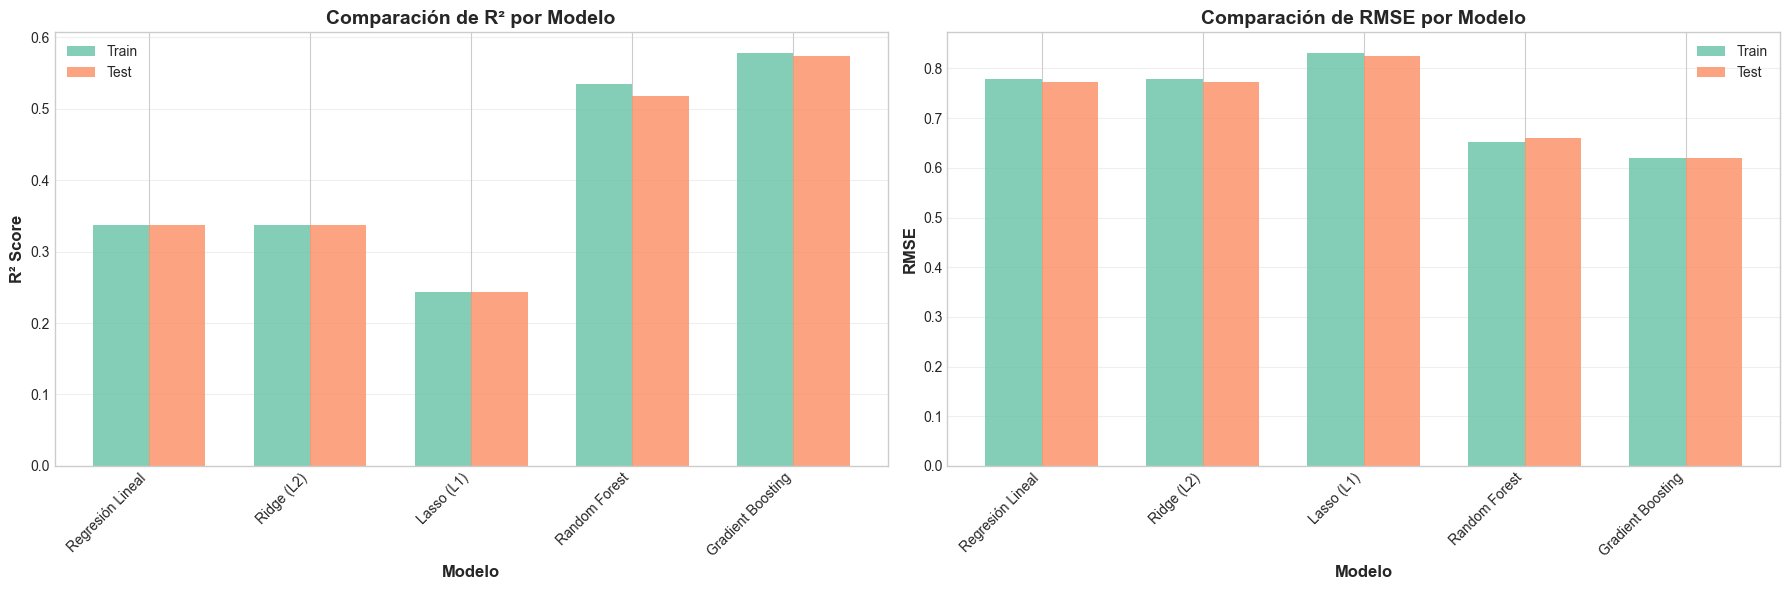

✓ Gráfico guardado: comparacion_modelos_imputacion.png


In [13]:
# Gráfico de comparación de modelos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# R² Score
ax1 = axes[0]
x_pos = np.arange(len(df_resultados))
width = 0.35

ax1.bar(x_pos - width/2, df_resultados['R² Train'], width, label='Train', alpha=0.8)
ax1.bar(x_pos + width/2, df_resultados['R² Test'], width, label='Test', alpha=0.8)

ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de R² por Modelo', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# RMSE
ax2 = axes[1]
ax2.bar(x_pos - width/2, df_resultados['RMSE Train'], width, label='Train', alpha=0.8)
ax2.bar(x_pos + width/2, df_resultados['RMSE Test'], width, label='Test', alpha=0.8)

ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Comparación de RMSE por Modelo', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../resultados/graficos/comparacion_modelos_imputacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: comparacion_modelos_imputacion.png")

## 6. Interpretación de Variables (Importancia)

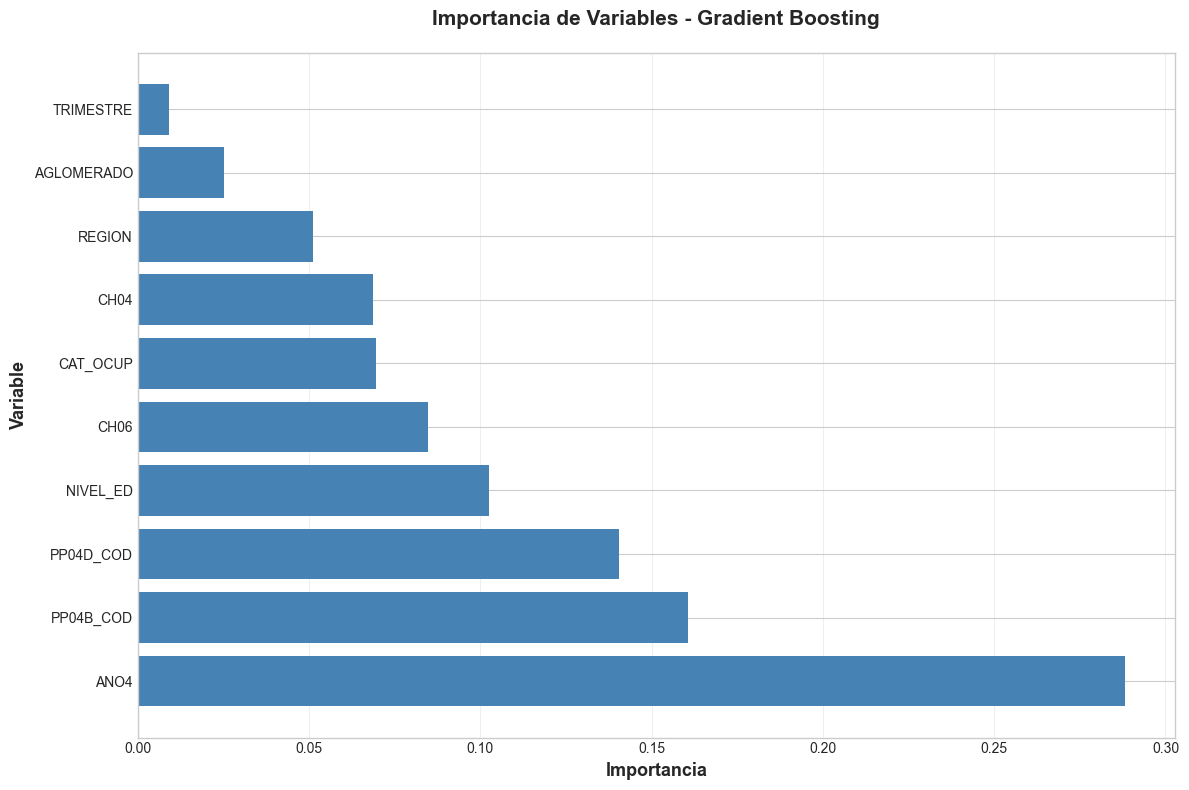

✓ Gráfico guardado: importancia_variables.png

Importancia de variables:
  Variable  Importancia
      ANO4         0.29
 PP04B_COD         0.16
 PP04D_COD         0.14
  NIVEL_ED         0.10
      CH06         0.08
  CAT_OCUP         0.07
      CH04         0.07
    REGION         0.05
AGLOMERADO         0.03
 TRIMESTRE         0.01


In [14]:
# Importancia de variables (si el modelo lo soporta)
if hasattr(mejor_modelo, 'feature_importances_'):
    # Random Forest o Gradient Boosting
    importancias = mejor_modelo.feature_importances_
    df_importancia = pd.DataFrame({
        'Variable': feature_cols,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.barh(df_importancia['Variable'], df_importancia['Importancia'], color='steelblue')
    ax.set_xlabel('Importancia', fontsize=13, fontweight='bold')
    ax.set_ylabel('Variable', fontsize=13, fontweight='bold')
    ax.set_title(f'Importancia de Variables - {mejor_modelo_nombre}', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('../resultados/graficos/importancia_variables.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: importancia_variables.png")
    print("\nImportancia de variables:")
    print(df_importancia.to_string(index=False))
    
elif hasattr(mejor_modelo, 'coef_'):
    # Regresión lineal, Ridge o Lasso
    coeficientes = mejor_modelo.coef_
    df_coef = pd.DataFrame({
        'Variable': feature_cols,
        'Coeficiente': coeficientes
    }).sort_values('Coeficiente', key=abs, ascending=False)
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = ['green' if c > 0 else 'red' for c in df_coef['Coeficiente']]
    ax.barh(df_coef['Variable'], df_coef['Coeficiente'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Coeficiente', fontsize=13, fontweight='bold')
    ax.set_ylabel('Variable', fontsize=13, fontweight='bold')
    ax.set_title(f'Coeficientes del Modelo - {mejor_modelo_nombre}', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('../resultados/graficos/coeficientes_modelo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: coeficientes_modelo.png")
    print("\nCoeficientes del modelo:")
    print(df_coef.to_string(index=False))
else:
    print("El modelo seleccionado no proporciona importancia de variables ni coeficientes.")

## 7. Gráfico de Predicciones vs. Valores Reales

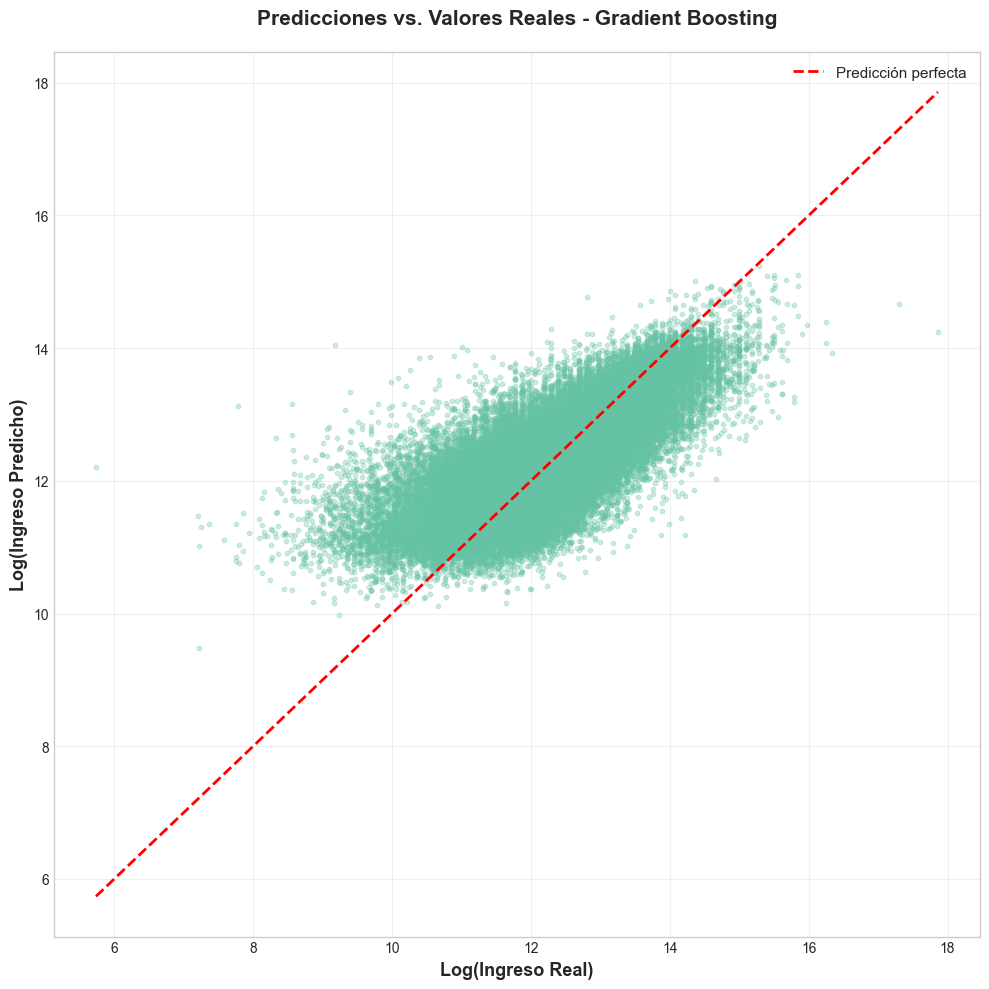

✓ Gráfico guardado: predicciones_vs_reales.png


In [15]:
# Obtener predicciones del mejor modelo
if mejor_modelo_nombre in ['Ridge (L2)', 'Lasso (L1)']:
    y_pred_final = mejor_modelo.predict(X_test_scaled)
else:
    y_pred_final = mejor_modelo.predict(X_test)

# Gráfico de dispersión
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_test, y_pred_final, alpha=0.3, s=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Predicción perfecta')

ax.set_xlabel('Log(Ingreso Real)', fontsize=13, fontweight='bold')
ax.set_ylabel('Log(Ingreso Predicho)', fontsize=13, fontweight='bold')
ax.set_title(f'Predicciones vs. Valores Reales - {mejor_modelo_nombre}', 
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../resultados/graficos/predicciones_vs_reales.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: predicciones_vs_reales.png")

## 8. Guardar Resultados

In [16]:
# Guardar tabla de resultados
df_resultados.to_csv('../resultados/tablas/resultados_modelos_imputacion.csv', index=False)
print("✓ Tabla guardada: resultados_modelos_imputacion.csv")

# Guardar importancia/coeficientes
if hasattr(mejor_modelo, 'feature_importances_'):
    df_importancia.to_csv('../resultados/tablas/importancia_variables.csv', index=False)
    print("✓ Tabla guardada: importancia_variables.csv")
elif hasattr(mejor_modelo, 'coef_'):
    df_coef.to_csv('../resultados/tablas/coeficientes_modelo.csv', index=False)
    print("✓ Tabla guardada: coeficientes_modelo.csv")

✓ Tabla guardada: resultados_modelos_imputacion.csv
✓ Tabla guardada: importancia_variables.csv


## 9. Resumen del Análisis

In [17]:
print("="*70)
print("RESUMEN DEL MODELO DE IMPUTACIÓN")
print("="*70)

print(f"\n1. DATOS")
print(f"   Total de ocupados: {len(df_ocupados):,}")
print(f"   Con ingreso válido: {df_ocupados['tiene_ingreso'].sum():,}")
print(f"   Tasa de respuesta: {(df_ocupados['tiene_ingreso'].sum() / len(df_ocupados)) * 100:.2f}%")

print(f"\n2. MEJOR MODELO")
print(f"   Nombre: {mejor_modelo_nombre}")
print(f"   R² (Test): {df_resultados.loc[mejor_idx, 'R² Test']:.4f}")
print(f"   RMSE (Test): {df_resultados.loc[mejor_idx, 'RMSE Test']:.4f}")
print(f"   MAE (Test): {df_resultados.loc[mejor_idx, 'MAE Test']:.4f}")

print(f"\n3. INTERPRETACIÓN")
print(f"   Un R² de {df_resultados.loc[mejor_idx, 'R² Test']:.2%} indica que el modelo explica")
print(f"   {df_resultados.loc[mejor_idx, 'R² Test']:.2%} de la variabilidad en los ingresos.")

if hasattr(mejor_modelo, 'feature_importances_'):
    top3 = df_importancia.head(3)
    print(f"\n   Las 3 variables más importantes son:")
    for i, row in top3.iterrows():
        print(f"     {i+1}. {row['Variable']} (Importancia: {row['Importancia']:.4f})")

print(f"\n{'='*70}")
print("Modelo de imputación completado ✓")
print(f"{'='*70}")

RESUMEN DEL MODELO DE IMPUTACIÓN

1. DATOS
   Total de ocupados: 476,423
   Con ingreso válido: 393,862
   Tasa de respuesta: 82.67%

2. MEJOR MODELO
   Nombre: Gradient Boosting
   R² (Test): 0.5738
   RMSE (Test): 0.6198
   MAE (Test): 0.4569

3. INTERPRETACIÓN
   Un R² de 57.38% indica que el modelo explica
   57.38% de la variabilidad en los ingresos.

   Las 3 variables más importantes son:
     7. ANO4 (Importancia: 0.2883)
     5. PP04B_COD (Importancia: 0.1606)
     6. PP04D_COD (Importancia: 0.1405)

Modelo de imputación completado ✓
